# COMP 3610 Project

### A PREDICTIVE MODEL FOR ELECTORAL OUTCOMES IN TRINIDAD & TOBAGO

Christophe Gittens  
Maia Neptune       
Zidane Timothy     

In [1]:
# initialize Program
# %pip install requests beautifulsoup4 python-csv
# %pip install pandas

import pandas as pd
import numpy as np
import csv
import os
import requests
from bs4 import BeautifulSoup

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
csvs_path = "csvs"

# Loading the datasets

### Electoral Data

In [2]:
election_results = pd.read_excel('csvs\collated-tt-election-results.xlsx', sheet_name=['2007', '2010', '2015','2020'], skiprows=[0,1,2,3,4])

# headers = 
# Access individual sheets using sheet names
sheet_1 = election_results['2007']
sheet_2 = election_results['2010']
sheet_3 = election_results['2015']
sheet_4 = election_results['2020']

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\maian\AppData\Local\Temp\ipykernel_41084\3116537911.py:1: SyntaxWarning: invalid escape sequence '\c'
  election_results = pd.read_excel('csvs\collated-tt-election-results.xlsx', sheet_name=['2007', '2010', '2015','2020'], skiprows=[0,1,2,3,4])


In [3]:
sheet_1.to_csv('election2007.csv')

2015

Sourcing macroeconomic data from the World Bank API. 
We will examine the the impact of the following:
Trinidad and Tobago's Debt to GDP ratio.
Trinidad and Tobago's GDP.
Trinidad and Tobago's Inflation.
Trinidad and Tobago's Government Expenditure
Trinidad and Tobago's Unemployment Rate. 

### Debt to GDP

In [4]:
cols = ["Date", "Central Government Domestic Debt to GDP Ratio (%)",
        "Central Government External Debt to GDP Ratio (%)",
        "Central Government Total Debt to GDP Ratio (%)",
        "Contingent Liabilities Debt to GDP Ratio (%)",
        "Gross Public Sector Debt to GDP Ratio (%)", 
        "Net Public Sector Debt to GDP Ratio (%)"
        ]
df_debt_annual = pd.read_csv(r'csvs\Debt Annual  Central Bank of Trinidad and Tobago.csv',
                             usecols = cols, low_memory = True)
df_debt_annual

,Date,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%)
0,2024,40.1,19.3,59.4,n.d,n.d,n.d
1,2023,40.6,18.5,59.1,n.d,n.d,n.d
2,2022,41.5,18.3,59.8,n.d,n.d,n.d
3,2021,42.0,17.5,59.4,n.d,n.d,n.d
4,2020,44.0,20.0,64.0,20.6,83.9,76.7
5,2019,44.1,18.7,62.8,21.0,83.4,73.2
6,2018,42.9,16.4,59.3,18.4,77.0,61.3
7,2017,41.7,14.8,56.5,17.8,73.6,58.5
8,2016,42.2,13.4,55.6,19.0,74.7,54.9
9,2015,40.1,8.8,48.8,19.2,68.2,47.8


### GDP

In [5]:


# url = 'https://api.worldbank.org/v2/country/TT/indicator/NY.GDP.MKTP.CD?format=json'
# response = requests.get(url)

# if response:
#     data = response.json()
#     tt_gdp = data[1]
#     df_gdp = pd.DataFrame(tt_gdp)
#     df_gdp.to_csv(os.path.join(csvs_path,r'tt_gdp.csv'))

# else:
#     print("Response is not 200.")

### Inflation

In [6]:
cols = ["Date", "Date",
        "Annual Average Percent Change in the Index of Retail Prices - Inflation Rate (%)",
        "Unemployment Rate (%)","WTI Crude Oil Price (US$/bbl)",
        "Henry Hub Natural Gas Price (US$/mmbtu)",
        "Net Official Reserves (US$Mn)"
        ]
df_inflation_annual = pd.read_csv(r'csvs\Selected Economic Indicators Annual  Central Bank of Trinidad and Tobago.csv',
                             usecols = cols, low_memory = True)

In [7]:
url = 'https://api.worldbank.org/v2/country/TT/indicator/FP.CPI.TOTL.ZG?format=json'
response = requests.get(url)

if response:
    data = response.json()
    tt_inflation = data[1]
    df_inflation = pd.DataFrame(tt_inflation)
    df_inflation.to_csv(os.path.join(csvs_path,r'tt_inflation.csv'))

else:
    print("Response is not 200 for inflation.")


### Unemployment rate

In [8]:
# cols = ["Date", "Unemployment Rate (%)"
#         ]
# df_unemployment_annual = pd.read_csv(r'csvs\Selected Economic Indicators Annual  Central Bank of Trinidad and Tobago.csv',
#                              usecols = cols, low_memory = True)

In [9]:
url = 'https://api.worldbank.org/v2/country/TT/indicator/SL.UEM.TOTL.ZS?format=json'
response = requests.get(url)

if response:
    data = response.json()
    tt_unemployment = data[1]
    df = pd.DataFrame(tt_unemployment)
    df.to_csv(os.path.join(csvs_path,r'tt_unemployment_rate.csv'))

else:
    print("Response is not 200.")

### Government expenditure

In [10]:
df_expenditure = pd.read_csv("csvs\Public Finance Annual  Central Bank of Trinidad and Tobago.csv")

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\maian\AppData\Local\Temp\ipykernel_41084\225322413.py:1: SyntaxWarning: invalid escape sequence '\P'
  df_expenditure = pd.read_csv("csvs\Public Finance Annual  Central Bank of Trinidad and Tobago.csv")


In [11]:
# url = 'https://api.worldbank.org/v2/country/TT/indicator/GC.XPN.TOTL.GD.ZS?format=json'
# response = requests.get(url)

# if response:
#     data = response.json()
#     tt_expenditure = data[1]
#     df_expenditure = pd.DataFrame(tt_expenditure)
#     df_expenditure.to_csv(os.path.join(csvs_path,r'tt_gov_expenditure.csv'))

# else:
#     print("Response is not 200.")

<!-- Debt_to_gdp -->

In [12]:
# url = 'https://api.worldbank.org/v2/country/TT/indicator/GC.XPN.TOTL.GD.ZS?format=json'
# response = requests.get(url)

# if response:
#     data = response.json()
#     tt_debt = data[1]
#     df = pd.DataFrame(tt_debt)
#     df.to_csv(os.path.join(csvs_path,r'tt_debt_to_gdp.csv'))

# else:
#     print("Response is not 200.")

### Homicide rate

In [13]:


# url ='https://www.macrotrends.net/global-metrics/countries/TTO/trinidad-and-tobago/murder-homicide-rate'

# headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
# }

# response = requests.get(url, headers=headers)

# if response:
#     soup = BeautifulSoup(response.content, 'html.parser')

#     div = soup.find('div', {'class': 'col-xs-6'})
#     crime_data =[]
#     if div:
#         table = div.find_all('table', {'class':'historical_data_table table table-striped table-bordered'})
#         table = table[0]
#     if table:
#         for row in table.find_all('tr')[2:]:
#             cells = row.find_all('td')
#             if len(cells) == 3:
#                 year = cells[0].get_text(strip=True)
#                 rate_per_100k = cells[1].get_text(strip=True)
#                 annual_change = cells[2].get_text(strip=True)
#                 crime_data.append([year,rate_per_100k,annual_change])

#         df_homicide_rate = pd.DataFrame(crime_data, columns=['Year','Rate_per_100k_Population','Annual_change'])

#         df_homicide_rate.to_csv(os.path.join(csvs_path,r'tt_homicide_rate.csv'), index=False)
# else:
#     print('Response is not 200.')

### Migration Rates

In [14]:


# url = "https://www.macrotrends.net/global-metrics/countries/TTO/trinidad-and-tobago/net-migration#:~:text=The%20net%20migration%20rate%20for,a%200.35%25%20decline%20from%202022."
# headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
# }

# response = requests.get(url, headers=headers)

# if response.status_code == 200:
#     soup = BeautifulSoup(response.text, "html.parser")
#     # print(soup.prettify())  # Check page structure
# else:
#     print("Failed to fetch page:", response.status_code)

# tables = soup.find_all("table")

# # ensure there are at least 2 tables before accessing the second one
# if len(tables) >= 2:
#     second_table = tables[1]  # Get the second table
#     df_migration_rate = pd.read_html(str(second_table))[0]
#     df_migration_rate.columns = ["Year", "Net Migration Rate", "Growth Rate"]
#     print(df_migration_rate)
# else:
#     print("Second table not found!")

# df_migration_rate.to_csv(os.path.join(csvs_path, r'tt_migration_rate.csv'), index=False)


### Currency Exchange Rate

In [15]:
df_exchange_rate = pd.read_csv("csvs\Exchange Rates Annual  Central Bank of Trinidad and Tobago (1).csv")
df_exchange_rate

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\maian\AppData\Local\Temp\ipykernel_41084\3618755825.py:1: SyntaxWarning: invalid escape sequence '\E'
  df_exchange_rate = pd.read_csv("csvs\Exchange Rates Annual  Central Bank of Trinidad and Tobago (1).csv")


,Date,Yen Buying,Yen Selling,US Buying,US Selling,Barbados Buying Rate,Barbados Selling Rate,Canadian Buying Rate,Canadian Selling Rate,Swiss Franc Buying Rate,Swiss Franc Selling Rate,EC Buying,EC Selling,Euro Buying,Euro Selling,Pound Buying,Pound Selling,Guyanese Buying,Guyanese Selling
0,2020,0.0630,0.0666,6.7204,6.7803,3.0145,3.5265,5.0261,5.3627,7.1418,7.4692,2.4017,2.6083,7.7617,8.2307,8.6183,9.2182,0.0308,0.0320
1,2019,0.0617,0.0653,6.7306,6.7800,2.9722,3.5199,5.0538,5.3813,6.6645,7.0753,2.4026,2.6062,7.5445,8.0224,8.5342,9.1294,0.0310,0.0321
2,2018,0.0609,0.0642,6.7321,6.7813,3.0253,3.5200,5.1438,5.4918,6.7467,7.2125,2.4105,2.6081,7.9261,8.4500,8.9231,9.5572,0.0311,0.0323
3,2017,0.0599,0.0628,6.7283,6.7795,3.2014,3.5195,5.1182,5.4517,6.6230,7.1055,2.4061,2.6132,7.5373,8.0093,8.6071,9.1537,0.0314,0.0326
4,2016,0.0632,0.0642,6.6152,6.6715,3.1694,3.4586,4.9425,5.2478,6.5403,6.9633,2.3779,2.5788,7.2682,7.6602,8.8462,9.4051,0.0314,0.0327
5,2015,0.0522,0.0546,6.3298,6.3776,3.0357,3.2837,4.8932,5.1793,6.4836,6.8578,2.2653,2.4485,6.9171,7.3032,9.5120,10.0569,0.0301,0.0312
6,2014,0.0602,0.0607,6.3613,6.4086,2.7995,3.2776,5.6779,5.9750,6.7732,7.2603,2.2761,2.4384,8.2714,8.6831,10.2525,10.7882,0.0303,0.0314
7,2013,0.0656,0.0662,6.3885,6.4426,2.7352,3.2935,6.1134,6.4166,6.7316,7.1737,2.2886,2.4468,8.2916,8.6617,9.7838,10.2313,0.0306,0.0329
8,2012,0.0799,0.0807,6.3716,6.4349,2.7123,3.2917,6.2971,6.5787,6.6408,7.0760,2.2977,2.4425,8.0181,8.3414,9.8817,10.3595,0.0306,0.0319
9,2011,0.0800,0.0807,6.3731,6.4261,2.7422,3.2816,6.3605,6.6262,7.1226,7.4970,2.2925,2.4321,8.6736,9.0375,9.9974,10.4562,0.0308,0.0320


# Preprocessing

From the central bank wevsite n.d. is No Data or NA so that is taken in consideration moving forward. Also all dates were kept as string as they just indicate the yeat

## Electoral Data

In [16]:
sheet_1

,Unnamed: 0,Unnamed: 1,VOTES CAST,Unnamed: 3,Unnamed: 4,POLLED,VOTES,%,VOTES.1,%.1,VOTES.2,%.2,VOTES.3,%.3,VOTES.4,%.4,VOTES.5,%.5
0,ARIMA,22845,13464,0.589363,91,13373,8603,0.643311,1224.0,0.091528,3464,0.259029,NaN,NaN,NaN,NaN,82.0,0.006132
1,AROUCA/MALONEY,23673,15948,0.673679,40,15908,12055,0.757795,1480.0,0.093035,2373,0.149170,NaN,NaN,NaN,NaN,NaN,NaN
2,BARATARIA/SAN JUAN,24597,16451,0.668821,93,16358,7179,0.438868,5362.0,0.327791,3817,0.233341,NaN,NaN,NaN,NaN,NaN,NaN
3,CARONI CENTRAL,22813,16640,0.729409,46,16594,4579,0.275943,7615.0,0.458901,4400,0.265156,NaN,NaN,NaN,NaN,NaN,NaN
4,CARONI EAST,23554,16460,0.698820,64,16396,3833,0.233777,8333.0,0.508234,4230,0.257990,NaN,NaN,NaN,NaN,NaN,NaN
5,CHAGUANAS EAST,22383,15887,0.709780,51,15836,6757,0.426686,4993.0,0.315294,4086,0.258020,NaN,NaN,NaN,NaN,NaN,NaN
6,CHAGUANAS WEST,24272,18029,0.742790,82,17947,1519,0.084638,11150.0,0.621274,5278,0.294088,NaN,NaN,NaN,NaN,NaN,NaN
7,COUVA NORTH,25898,18992,0.733338,72,18920,5249,0.277431,8832.0,0.466808,4839,0.255761,NaN,NaN,NaN,NaN,NaN,NaN
8,COUVA SOUTH,25188,17987,0.714110,53,17934,5097,0.284209,8428.0,0.469945,4409,0.245846,NaN,NaN,NaN,NaN,NaN,NaN
9,CUMUTO/MANZANILLA,24700,17751,0.718664,76,17675,7124,0.403055,7368.0,0.416860,3183,0.180085,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
sheet_1.isna().sum()

Unnamed: 0     0
Unnamed: 1     0
VOTES CAST     0
Unnamed: 3     0
Unnamed: 4     0
POLLED         0
VOTES          0
%              0
VOTES.1        2
%.1            2
VOTES.2        0
%.2            0
VOTES.3       39
%.3           39
VOTES.4       39
%.4           39
VOTES.5       37
%.5           37
dtype: int64

In [18]:
# sht_07, sht_10, sht_15, sht_20 = sheet_2007.iloc[3:], sheet_2010.iloc[3:], sheet_2015.iloc[3:], sheet_2020.iloc[3:]

# print(sht_07)
# print(sht_10)
# print(sht_15)
# print(sht_20)
# sht_20

In [19]:
sheet_1.shape

(42, 18)

Fixing headers

2007

In [20]:
cols= [
            'ELECTORAL_DISTRICT', 'ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST',
            'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES', 'P.N.M._VOTES',
            'P.N.M._VOTES_%', 'U.N.C._VOTES','U.N.C._VOTES_%', 'C.O.P._VOTES', 
            'C.O.P._VOTES_%', 'D.A.C._VOTES', 'D.A.C._VOTES_%', 'D.N.A._VOTES', 
            'D.N.A._VOTES_%', 'I.N.D_VOTES', 'I.N.D._VOTES_%'
        ]
sht_07 = sheet_1
sht_07.columns = cols
sht_07.fillna(0, inplace=True)
sht_07

,ELECTORAL_DISTRICT,ELECTORATE,TOTAL_NUMBER_OF_VOTES_CAST,VOTER_TURNOUT,REJECTED_BALLOTS,VALID_VOTES,P.N.M._VOTES,P.N.M._VOTES_%,U.N.C._VOTES,U.N.C._VOTES_%,C.O.P._VOTES,C.O.P._VOTES_%,D.A.C._VOTES,D.A.C._VOTES_%,D.N.A._VOTES,D.N.A._VOTES_%,I.N.D_VOTES,I.N.D._VOTES_%
0,ARIMA,22845,13464,0.589363,91,13373,8603,0.643311,1224.0,0.091528,3464,0.259029,0.0,0.000000,0.0,0.000000,82.0,0.006132
1,AROUCA/MALONEY,23673,15948,0.673679,40,15908,12055,0.757795,1480.0,0.093035,2373,0.149170,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,BARATARIA/SAN JUAN,24597,16451,0.668821,93,16358,7179,0.438868,5362.0,0.327791,3817,0.233341,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,CARONI CENTRAL,22813,16640,0.729409,46,16594,4579,0.275943,7615.0,0.458901,4400,0.265156,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,CARONI EAST,23554,16460,0.698820,64,16396,3833,0.233777,8333.0,0.508234,4230,0.257990,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,CHAGUANAS EAST,22383,15887,0.709780,51,15836,6757,0.426686,4993.0,0.315294,4086,0.258020,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,CHAGUANAS WEST,24272,18029,0.742790,82,17947,1519,0.084638,11150.0,0.621274,5278,0.294088,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,COUVA NORTH,25898,18992,0.733338,72,18920,5249,0.277431,8832.0,0.466808,4839,0.255761,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,COUVA SOUTH,25188,17987,0.714110,53,17934,5097,0.284209,8428.0,0.469945,4409,0.245846,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,CUMUTO/MANZANILLA,24700,17751,0.718664,76,17675,7124,0.403055,7368.0,0.416860,3183,0.180085,0.0,0.000000,0.0,0.000000,0.0,0.000000


2010

In [21]:
cols = [
            'ELECTORAL_DISTRICT', 'ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST',
            'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES', 'P.N.M._VOTES',
            'P.N.M._VOTES_%', 'U.N.C._VOTES','U.N.C._VOTES_%', 'C.O.P._VOTES', 
            'C.O.P._VOTES_%', 'N.N.V._VOTES', 'N.N.V._VOTES_%', 'T.O.P._VOTES', 
            'T.O.P._VOTES_%', 'T.H.C._VOTES', 'T.H.C._VOTES_%', 'I.N.D_VOTES', 
            'I.N.D._VOTES_%', 'T.T.N.C.P._VOTES', 'T.T.N.C.P._VOTES_%'
        ]

sht_10 = sheet_2
sht_10.columns = cols
sht_10.fillna(0, inplace=True)
sht_10

,ELECTORAL_DISTRICT,ELECTORATE,TOTAL_NUMBER_OF_VOTES_CAST,VOTER_TURNOUT,REJECTED_BALLOTS,VALID_VOTES,P.N.M._VOTES,P.N.M._VOTES_%,U.N.C._VOTES,U.N.C._VOTES_%,...,N.N.V._VOTES,N.N.V._VOTES_%,T.O.P._VOTES,T.O.P._VOTES_%,T.H.C._VOTES,T.H.C._VOTES_%,I.N.D_VOTES,I.N.D._VOTES_%,T.T.N.C.P._VOTES,T.T.N.C.P._VOTES_%
0,ARIMA,24115,15130,0.627410,73,15057,7246,0.481238,0.0,0.000000,...,201.0,0.013349,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,AROUCA/MALONEY,25019,17196,0.687318,46,17150,11517,0.671545,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,113.0,0.006589,0.0,0.000000
2,BARATARIA/SAN JUAN,25394,17768,0.699693,76,17692,6742,0.381076,10950.0,0.618924,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,CARONI CENTRAL,24601,18793,0.763912,50,18743,4880,0.260364,13863.0,0.739636,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,CARONI EAST,25166,18762,0.745530,57,18705,3724,0.199091,14981.0,0.800909,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,CHAGUANAS EAST,23653,17611,0.744557,58,17553,6717,0.382670,10797.0,0.615109,...,39.0,0.002222,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,CHAGUANAS WEST,25715,20281,0.788684,70,20211,1471,0.072782,18740.0,0.927218,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,COUVA NORTH,27680,21286,0.769003,70,21216,5159,0.243166,16057.0,0.756834,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,COUVA SOUTH,26400,19877,0.752917,59,19818,4773,0.240842,15045.0,0.759158,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,CUMUTO/MANZANILLA,26896,20527,0.763199,121,20406,7181,0.351906,13116.0,0.642752,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,109.0,0.005342,0.0,0.000000


In [22]:
cols = [
            'ELECTORAL_DISTRICT', 'ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST',
            'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES', 'P.N.M._VOTES',
            'P.N.M._VOTES_%', 'U.N.C._VOTES','U.N.C._VOTES_%', 'C.O.P._VOTES', 
            'C.O.P._VOTES_%', 'I.L.P._VOTES', 'I.L.P._VOTES_%', 'N.J.A.C._VOTES',
            'N.J.A.C._VOTES_%','D.D.P._VOTES', 'D.D.P._VOTES_%', 'I.D.P._VOTES',
            'I.D.P._VOTES_%', 'I.N.D_VOTES', 'I.N.D._VOTES_%', 'L.O.V.E._VOTES',
            'L.O.V.E._VOTES_%', 'N.C.T._VOTES', 'N.C.T._VOTES_%','N.N.V._VOTES',
            'N.N.V._VOTES_%','T.F._VOTES', 'T.F._VOTES_%', 'T.O.P._VOTES', 
            'T.O.P._VOTES_%', 'T.H.C._VOTES', 'T.H.C._VOTES_%', 'T.N.V._VOTES',
            'T.N.V._VOTES_%', 'T.P.T._VOTES', 'T.P.T._VOTES_%', 'Y.E.P._VOTES', 
            'Y.E.P._VOTES_%', 'Y.O.U.R._VOTES', 'Y.O.U.R._VOTES_%',
        ]
sht_15 = sheet_3
sht_15.columns = cols
sht_15.fillna(0, inplace=True)
sht_15

,ELECTORAL_DISTRICT,ELECTORATE,TOTAL_NUMBER_OF_VOTES_CAST,VOTER_TURNOUT,REJECTED_BALLOTS,VALID_VOTES,P.N.M._VOTES,P.N.M._VOTES_%,U.N.C._VOTES,U.N.C._VOTES_%,...,T.H.C._VOTES,T.H.C._VOTES_%,T.N.V._VOTES,T.N.V._VOTES_%,T.P.T._VOTES,T.P.T._VOTES_%,Y.E.P._VOTES,Y.E.P._VOTES_%,Y.O.U.R._VOTES,Y.O.U.R._VOTES_%
0,ARIMA,25555,15761,0.616748,56,15705,10879,0.695200,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,AROUCA/MALONEY,26321,18250,0.693363,50,18200,14843,0.815500,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,BARATARIA/SAN JUAN,25529,16970,0.664734,32,16938,8182,0.483056,8722.0,0.514937,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,34.0,0.002007,0.0,0.000000
3,CARONI CENTRAL,27887,19731,0.707534,37,19694,7206,0.365898,12349.0,0.627044,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,CARONI EAST,27602,18863,0.683393,41,18822,5095,0.270694,13525.0,0.718574,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,CHAGUANAS EAST,25488,17942,0.703939,27,17915,7860,0.438738,9284.0,0.518225,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,CHAGUANAS WEST,27704,20179,0.728379,65,20114,2190,0.108879,17506.0,0.870339,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,COUVA NORTH,29284,20816,0.710832,46,20770,6749,0.324940,13845.0,0.666586,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,COUVA SOUTH,28499,20186,0.708306,50,20136,6070,0.301450,13889.0,0.689760,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,CUMUTO/MANZANILLA,28152,20004,0.710571,75,19929,8282,0.415575,11461.0,0.575092,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


2020

In [23]:
cols = [
            'ELECTORAL_DISTRICT', 'ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST',
            'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES', 'P.N.M._VOTES',
            'P.N.M._VOTES_%', 'U.N.C._VOTES','U.N.C._VOTES_%','P.E.P._VOTES', 
            'P.E.P._VOTES_%', 'C.O.P._VOTES', 'C.O.P._VOTES_%', 'I.L.P._VOTES', 
            'I.L.P._VOTES_%', 'D.P.T._VOTES', 'D.P.T._VOTES_%', 'I.N.D_VOTES', 
            'I.N.D._VOTES_%','M.N.D._VOTES', 'M.N.D._VOTES_%', 'M.S.J._VOTES',
            'M.S.J._VOTES_%', 'N.C.T._VOTES', 'N.C.T._VOTES_%','N.N.V._VOTES',
            'N.N.V._VOTES_%','N.O.W._VOTES', 'N.O.W._VOTES_%', 'O.T.V._VOTES', 
            'O.T.V._VOTES_%', 'P.D.P._VOTES', 'P.D.P._VOTES_%', 'P.P._VOTES', 
            'P.P._VOTES_%', 'T.D.F._VOTES', 'T.D.F._VOTES_%', 'T.H.C._VOTES', 
            'T.H.C._VOTES_%', 'T.N.P._VOTES', 'T.N.P._VOTES_%', 'U.P.P._VOTES', 
            'U.P.P._VOTES_%', 'U.T.P._VOTES', 'U.T.P._VOTES_%'
        ]
sht_20 = sheet_4
sht_20.columns = cols
sht_20.fillna(0, inplace=True)
sht_20

,ELECTORAL_DISTRICT,ELECTORATE,TOTAL_NUMBER_OF_VOTES_CAST,VOTER_TURNOUT,REJECTED_BALLOTS,VALID_VOTES,P.N.M._VOTES,P.N.M._VOTES_%,U.N.C._VOTES,U.N.C._VOTES_%,...,T.D.F._VOTES,T.D.F._VOTES_%,T.H.C._VOTES,T.H.C._VOTES_%,T.N.P._VOTES,T.N.P._VOTES_%,U.P.P._VOTES,U.P.P._VOTES_%,U.T.P._VOTES,U.T.P._VOTES_%
0,ARIMA,26382,13488,0.511258,30,13458,9293,0.695200,3858.0,0.286670,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,AROUCA/MALONEY,26673,15522,0.581937,57,15465,12697,0.815500,2768.0,0.178985,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,BARATARIA/SAN JUAN,25690,15771,0.613896,27,15744,7240,0.459858,8300.0,0.527185,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,CARONI CENTRAL,30107,18677,0.620354,31,18646,6890,0.369516,11511.0,0.617344,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,CARONI EAST,29031,17416,0.599910,30,17386,4271,0.245657,12819.0,0.737317,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,CHAGUANAS EAST,26923,17125,0.636073,53,17072,7882,0.461692,8968.0,0.525305,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,CHAGUANAS WEST,28625,17566,0.613659,48,17518,1878,0.107204,15502.0,0.884918,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,COUVA NORTH,29864,18238,0.610702,25,18213,5222,0.286718,12633.0,0.693625,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,COUVA SOUTH,30348,18281,0.602379,36,18245,5542,0.303754,12597.0,0.690436,...,0.0,0.000000,106.0,0.005810,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,CUMUTO/MANZANILLA,30468,18702,0.613824,51,18651,7557,0.405179,10901.0,0.584473,...,0.0,0.000000,35.0,0.001877,0.0,0.000000,0.0,0.000000,0.0,0.000000


## Debt to GDP cleaning

In [24]:
df_debt_annual

,Date,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%)
0,2024,40.1,19.3,59.4,n.d,n.d,n.d
1,2023,40.6,18.5,59.1,n.d,n.d,n.d
2,2022,41.5,18.3,59.8,n.d,n.d,n.d
3,2021,42.0,17.5,59.4,n.d,n.d,n.d
4,2020,44.0,20.0,64.0,20.6,83.9,76.7
5,2019,44.1,18.7,62.8,21.0,83.4,73.2
6,2018,42.9,16.4,59.3,18.4,77.0,61.3
7,2017,41.7,14.8,56.5,17.8,73.6,58.5
8,2016,42.2,13.4,55.6,19.0,74.7,54.9
9,2015,40.1,8.8,48.8,19.2,68.2,47.8


In [25]:
df_debt_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Date                                               25 non-null     int64  
 1   Central Government Domestic Debt to GDP Ratio (%)  25 non-null     float64
 2   Central Government External Debt to GDP Ratio (%)  25 non-null     float64
 3   Central Government Total Debt to GDP Ratio (%)     25 non-null     float64
 4   Contingent Liabilities Debt to GDP Ratio (%)       25 non-null     object 
 5   Gross Public Sector Debt to GDP Ratio (%)          25 non-null     object 
 6   Net Public Sector Debt to GDP Ratio (%)            25 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ KB


In [26]:
df_debt_annual["Date"] = df_debt_annual["Date"].astype("int64")
df_debt_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Date                                               25 non-null     int64  
 1   Central Government Domestic Debt to GDP Ratio (%)  25 non-null     float64
 2   Central Government External Debt to GDP Ratio (%)  25 non-null     float64
 3   Central Government Total Debt to GDP Ratio (%)     25 non-null     float64
 4   Contingent Liabilities Debt to GDP Ratio (%)       25 non-null     object 
 5   Gross Public Sector Debt to GDP Ratio (%)          25 non-null     object 
 6   Net Public Sector Debt to GDP Ratio (%)            25 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ KB


In [27]:
# Replace String values with numeric values and convert to float
df_debt_annual[["Contingent Liabilities Debt to GDP Ratio (%)",
                "Gross Public Sector Debt to GDP Ratio (%)",
                "Net Public Sector Debt to GDP Ratio (%)"]] = df_debt_annual[["Contingent Liabilities Debt to GDP Ratio (%)",
                "Gross Public Sector Debt to GDP Ratio (%)",
                "Net Public Sector Debt to GDP Ratio (%)"]].replace("n.d",0)

df_debt_annual[["Contingent Liabilities Debt to GDP Ratio (%)",
                "Gross Public Sector Debt to GDP Ratio (%)",
                "Net Public Sector Debt to GDP Ratio (%)"]] = df_debt_annual[["Contingent Liabilities Debt to GDP Ratio (%)",
                "Gross Public Sector Debt to GDP Ratio (%)",
                "Net Public Sector Debt to GDP Ratio (%)"]].astype(float)

In [28]:
df_debt_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Date                                               25 non-null     int64  
 1   Central Government Domestic Debt to GDP Ratio (%)  25 non-null     float64
 2   Central Government External Debt to GDP Ratio (%)  25 non-null     float64
 3   Central Government Total Debt to GDP Ratio (%)     25 non-null     float64
 4   Contingent Liabilities Debt to GDP Ratio (%)       25 non-null     float64
 5   Gross Public Sector Debt to GDP Ratio (%)          25 non-null     float64
 6   Net Public Sector Debt to GDP Ratio (%)            25 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 1.5 KB


In [29]:
df_debt_annual.describe()

,Date,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%)
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2012.000000,31.180000,12.628000,43.792000,7.968000,29.260000,22.508000
std,7.359801,9.923667,5.671752,13.722303,9.245482,34.792983,27.686427
min,2000.000000,16.800000,5.300000,23.400000,0.000000,0.000000,0.000000
25%,2006.000000,23.000000,7.300000,34.300000,0.000000,0.000000,0.000000
50%,2012.000000,28.600000,13.400000,43.300000,0.000000,0.000000,0.000000
75%,2018.000000,41.500000,18.300000,59.100000,17.800000,66.500000,45.200000
max,2024.000000,44.100000,21.500000,64.000000,21.000000,83.900000,76.700000


In [30]:
df_debt_annual.isna().sum()

Date                                                 0
Central Government Domestic Debt to GDP Ratio (%)    0
Central Government External Debt to GDP Ratio (%)    0
Central Government Total Debt to GDP Ratio (%)       0
Contingent Liabilities Debt to GDP Ratio (%)         0
Gross Public Sector Debt to GDP Ratio (%)            0
Net Public Sector Debt to GDP Ratio (%)              0
dtype: int64

In [31]:
df_debt_annual.isna().any()

Date                                                 False
Central Government Domestic Debt to GDP Ratio (%)    False
Central Government External Debt to GDP Ratio (%)    False
Central Government Total Debt to GDP Ratio (%)       False
Contingent Liabilities Debt to GDP Ratio (%)         False
Gross Public Sector Debt to GDP Ratio (%)            False
Net Public Sector Debt to GDP Ratio (%)              False
dtype: bool

The data for debt to gdp looks cleaned enough. 

## GDP

In [32]:
df_gdp = pd.read_csv("csvs/tt_gdp.csv")

In [33]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       50 non-null     int64  
 1   indicator        50 non-null     object 
 2   country          50 non-null     object 
 3   countryiso3code  50 non-null     object 
 4   date             50 non-null     int64  
 5   value            50 non-null     float64
 6   unit             0 non-null      float64
 7   obs_status       0 non-null      float64
 8   decimal          50 non-null     int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 3.6+ KB


In [34]:
df_gdp["date"] = df_gdp["date"].astype("int64")
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       50 non-null     int64  
 1   indicator        50 non-null     object 
 2   country          50 non-null     object 
 3   countryiso3code  50 non-null     object 
 4   date             50 non-null     int64  
 5   value            50 non-null     float64
 6   unit             0 non-null      float64
 7   obs_status       0 non-null      float64
 8   decimal          50 non-null     int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 3.6+ KB


In [35]:
df_gdp.isna().sum()

Unnamed: 0          0
indicator           0
country             0
countryiso3code     0
date                0
value               0
unit               50
obs_status         50
decimal             0
dtype: int64

In [36]:
df_gdp.isna().all()

Unnamed: 0         False
indicator          False
country            False
countryiso3code    False
date               False
value              False
unit                True
obs_status          True
decimal            False
dtype: bool

In [37]:
df_gdp.describe()

,Unnamed: 0,date,value,unit,obs_status,decimal
count,50.00000,50.00000,5.000000e+01,0.0,0.0,50.0
mean,24.50000,1998.50000,1.297770e+10,NaN,NaN,0.0
std,14.57738,14.57738,9.489073e+09,NaN,NaN,0.0
min,0.00000,1974.00000,2.042001e+09,NaN,NaN,0.0
25%,12.25000,1986.25000,5.127976e+09,NaN,NaN,0.0
50%,24.50000,1998.50000,7.952083e+09,NaN,NaN,0.0
75%,36.75000,2010.75000,2.333149e+10,NaN,NaN,0.0
max,49.00000,2023.00000,3.005345e+10,NaN,NaN,0.0


## Inflation

In [38]:
df_inflation

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2023,4.629302,,,1
1,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2022,5.828386,,,1
2,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2021,2.059227,,,1
3,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2020,0.598986,,,1
4,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2019,1.000543,,,1
5,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2018,1.018569,,,1
6,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2017,1.880384,,,1
7,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2016,3.070667,,,1
8,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2015,4.661216,,,1
9,"{'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, ...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2014,5.684418,,,1


In [39]:
df_inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   indicator        50 non-null     object 
 1   country          50 non-null     object 
 2   countryiso3code  50 non-null     object 
 3   date             50 non-null     object 
 4   value            50 non-null     float64
 5   unit             50 non-null     object 
 6   obs_status       50 non-null     object 
 7   decimal          50 non-null     int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 3.3+ KB


In [40]:
df_inflation["date"] = df_inflation['date'].astype("int64")
df_inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   indicator        50 non-null     object 
 1   country          50 non-null     object 
 2   countryiso3code  50 non-null     object 
 3   date             50 non-null     int64  
 4   value            50 non-null     float64
 5   unit             50 non-null     object 
 6   obs_status       50 non-null     object 
 7   decimal          50 non-null     int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ KB


In [41]:
df_inflation.isna().sum()

indicator          0
country            0
countryiso3code    0
date               0
value              0
unit               0
obs_status         0
decimal            0
dtype: int64

In [42]:
df_inflation.isna().all()

indicator          False
country            False
countryiso3code    False
date               False
value              False
unit               False
obs_status         False
decimal            False
dtype: bool

The commented code is for inflation extractedd from the Central Bank of Trinidad and Tobago (CBTT) and is more concise

In [43]:
# df_inflation_annual.info()

In [44]:
# df_inflation_annual.describe()

In [45]:
# df_inflation_annual.isna().sum()

## Unemployment Values cleaning

In [46]:
df_unemployment = pd.read_csv("csvs/tt_unemployment_rate.csv")

# Convert all values in df_unemployment to more readable values
df_unemployment['value'] = df_unemployment['value'].apply(lambda x: round(x, 2))
df_unemployment.rename(columns={'value': 'Unemployment Rate (%)'}, inplace=True)
df_unemployment

,Unnamed: 0,indicator,country,countryiso3code,date,Unemployment Rate (%),unit,obs_status,decimal
0,0,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2100,NaN,NaN,NaN,1
1,1,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2095,NaN,NaN,NaN,1
2,2,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2090,NaN,NaN,NaN,1
3,3,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2085,NaN,NaN,NaN,1
4,4,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2080,NaN,NaN,NaN,1
5,5,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2075,NaN,NaN,NaN,1
6,6,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2070,NaN,NaN,NaN,1
7,7,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2065,NaN,NaN,NaN,1
8,8,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2060,NaN,NaN,NaN,1
9,9,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2055,NaN,NaN,NaN,1


In [47]:
df_unemployment = df_unemployment.drop(columns={"unit", "obs_status", "decimal"})
df_unemployment

,Unnamed: 0,indicator,country,countryiso3code,date,Unemployment Rate (%)
0,0,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2100,NaN
1,1,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2095,NaN
2,2,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2090,NaN
3,3,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2085,NaN
4,4,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2080,NaN
5,5,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2075,NaN
6,6,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2070,NaN
7,7,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2065,NaN
8,8,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2060,NaN
9,9,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2055,NaN


In [48]:
df_unemployment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             50 non-null     int64  
 1   indicator              50 non-null     object 
 2   country                50 non-null     object 
 3   countryiso3code        50 non-null     object 
 4   date                   50 non-null     int64  
 5   Unemployment Rate (%)  9 non-null      float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5+ KB


In [49]:
df_unemployment["date"] = df_unemployment['date'].astype("int64")
df_unemployment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             50 non-null     int64  
 1   indicator              50 non-null     object 
 2   country                50 non-null     object 
 3   countryiso3code        50 non-null     object 
 4   date                   50 non-null     int64  
 5   Unemployment Rate (%)  9 non-null      float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5+ KB


In [50]:
df_unemployment.isna().sum()

Unnamed: 0                0
indicator                 0
country                   0
countryiso3code           0
date                      0
Unemployment Rate (%)    41
dtype: int64

Since we are only looking at 2000/2002 onward we can drop all the empty rows since they are not part of our dataset

In [51]:
df_unemployment.dropna(subset=['Unemployment Rate (%)'], inplace=True)
df_unemployment.isna().sum()

Unnamed: 0               0
indicator                0
country                  0
countryiso3code          0
date                     0
Unemployment Rate (%)    0
dtype: int64

In [52]:
df_unemployment.isna().all()

Unnamed: 0               False
indicator                False
country                  False
countryiso3code          False
date                     False
Unemployment Rate (%)    False
dtype: bool

In [53]:
df_unemployment

,Unnamed: 0,indicator,country,countryiso3code,date,Unemployment Rate (%)
41,41,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2019,2.69
42,42,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2018,2.50
43,43,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2017,2.71
44,44,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2016,2.97
45,45,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2015,2.21
46,46,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2014,2.22
47,47,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2013,2.46
48,48,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2012,3.45
49,49,"{'id': 'SL.UEM.TOTL.ZS', 'value': 'Unemploymen...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",TTO,2011,3.25


In [54]:
df_unemployment.describe()

,Unnamed: 0,date,Unemployment Rate (%)
count,9.000000,9.000000,9.000000
mean,45.000000,2015.000000,2.717778
std,2.738613,2.738613,0.433497
min,41.000000,2011.000000,2.210000
25%,43.000000,2013.000000,2.460000
50%,45.000000,2015.000000,2.690000
75%,47.000000,2017.000000,2.970000
max,49.000000,2019.000000,3.450000


The commented code is for inflation extractedd from the Central Bank of Trinidad and Tobago (CBTT) and is more concise

In [55]:
# df_unemployment_annual.info()

In [56]:
# df_unemployment_annual.describe()

In [57]:
# df_unemployment_annual.isna().sum()

In [58]:
# df_unemployment_annual.isna().any()

## Government Expenditure

In [59]:
df_expenditure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Date                                            25 non-null     int64  
 1   Central Government Total Expenditure (TT$Mn)    25 non-null     float64
 2   Central Government Current Expenditure (TT$Mn)  25 non-null     float64
 3   Total Revenue as a Per Cent of GDP              25 non-null     float64
 4   Total Expenditure as a Per Cent of GDP          25 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.1 KB


In [60]:
df_expenditure['Date'] = df_expenditure['Date'].astype("int64")
df_expenditure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Date                                            25 non-null     int64  
 1   Central Government Total Expenditure (TT$Mn)    25 non-null     float64
 2   Central Government Current Expenditure (TT$Mn)  25 non-null     float64
 3   Total Revenue as a Per Cent of GDP              25 non-null     float64
 4   Total Expenditure as a Per Cent of GDP          25 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.1 KB


In [61]:
df_expenditure.isna().sum()

Date                                              0
Central Government Total Expenditure (TT$Mn)      0
Central Government Current Expenditure (TT$Mn)    0
Total Revenue as a Per Cent of GDP                0
Total Expenditure as a Per Cent of GDP            0
dtype: int64

In [62]:
df_expenditure.isna().all()

Date                                              False
Central Government Total Expenditure (TT$Mn)      False
Central Government Current Expenditure (TT$Mn)    False
Total Revenue as a Per Cent of GDP                False
Total Expenditure as a Per Cent of GDP            False
dtype: bool

Given the only important missing values are 2020 and 2000 expenditure values, we can source those two and drop the other rows that we are empty

## Homicide Rate

In [63]:
df_homicide_rate = pd.read_csv(r"csvs\tt_homicide_rate.csv") #rate per 100k for 2023 and 2023 sourced from statista.com others from macrotrend.com

#pct_change will make Annual_change row for first value null
df_homicide_rate['Annual_change'] = df_homicide_rate["Annual_change"].replace(to_replace=' ', value=0)
df_homicide_rate['Annual_change'] = df_homicide_rate["Annual_change"].str.rstrip('%').astype('float')
last_homicide_row = df_homicide_rate.iloc[-1:]

df_homicide_rate= df_homicide_rate.sort_values(by='Year')
df_homicide_rate['Annual_change'] = (df_homicide_rate['Rate_per_100k_Population'].pct_change()* 100).round(2) 
df_homicide_rate= df_homicide_rate.sort_values(by='Year', ascending=False)

df_homicide_rate.iloc[-1:] = last_homicide_row

df_homicide_rate

,Year,Rate_per_100k_Population,Annual_change,Total_murders_per_year
0,2024,45.70,21.54,625
1,2023,37.60,-12.96,577
2,2022,43.20,47.14,605
3,2021,29.36,11.72,450
4,2020,26.28,-25.89,399
5,2019,35.46,3.20,539
6,2018,34.36,2.63,517
7,2017,33.48,6.25,495
8,2016,31.51,9.56,462
9,2015,28.76,3.01,420


In [64]:
df_homicide_by_div = pd.read_csv(r'csvs\tt_murders_by_division_2013_2024.csv')
df_homicide_by_div['Year'] = df_homicide_by_div['Year'].astype('int64')
df_homicide_by_div = pd.merge(df_homicide_rate, df_homicide_by_div, on='Year', how='outer')


## Constituency/Division Specific Homicide Information
Incase accuracy is low. This will be employed for the SVM.

In [65]:
#melting the df
df_long_homicide_by_div = df_homicide_by_div.melt(id_vars=['Year', 'Rate_per_100k_Population', 'Annual_change','Total_murders_per_year'], 
                  var_name='Division', 
                  value_name='Murders')

In [66]:
def murder_estimate(division, df_long):
    division_data = df_long[df_long['Division'] == division].copy()

    murders_2013 = division_data[division_data['Year'] == 2013]['Murders'].values[0]

    for year in range(2012, 1999, -1):
        try:
            pct_change = division_data[division_data['Year'] == year + 1]['Annual_change'].values[0]
        except IndexError:
            continue  

        projected_murders = (murders_2013 / (1 + pct_change / 100)).round()

        mask = (df_long['Year'] == year) & (df_long['Division'] == division)
        if df_long.loc[mask, 'Murders'].isna().any():
            df_long.loc[mask, 'Murders'] = projected_murders
        else:
            new_row = {
                'Year': year,
                'Division': division,
                'Rate_per_100k_Population': np.nan,
                'Annual_change': np.nan,
                'Murders': projected_murders,
                'Annual_change': np.nan
            }
            df_long = pd.concat([df_long, pd.DataFrame([new_row])], ignore_index=True)

        murders_2013 = projected_murders

    return df_long

In [67]:
divisions = df_long_homicide_by_div['Division'].dropna().unique()

for division in divisions:
    df_long_homicide_by_div = murder_estimate(division, df_long_homicide_by_div)

In [68]:
#testing to see if data is accurate
#quote "When murder data are restricted to 2001-2013, the
# largest proportion of murders in Trinidad and Tobago took place in the Port of Spain Division
# (26.7 per cent). This was followed by the Northern Division (19.9 per cent), North Eastern
# Division (13.3 per cent), and Western Division (12.3 per cent)."

subset = df_long_homicide_by_div[(df_long_homicide_by_div['Year'] >= 2001) & (df_long_homicide_by_div['Year'] <= 2013)]

total_by_division = subset.groupby('Division')['Murders'].sum()
grand_total = total_by_division.sum()

division_percentages = (total_by_division / grand_total) * 100
division_percentages = division_percentages.sort_values(ascending=False)
print(division_percentages)



Division
Port_of_Spain    29.576588
Nothern          20.070569
North_Eastern    12.391034
Western          10.564550
Central           8.758821
Southern          8.447489
Eastern           4.586966
South_Western     4.586966
Tobago            1.017020
Name: Murders, dtype: float64


From: 1. Crime-Trinidad and Tobago. 2. Crime prevention-Trinidad and Tobago. 3. ViolenceTrinidad and Tobago. 4. Violence-Prevention-Trinidad and Tobago. I. Inter-American
Development Bank. Country Department Caribbean Group. II. Title. III. Series.
IDB-TN-1062 

"When murder data are restricted to 2001-2013, the largest proportion of murders in Trinidad and Tobago took place in the Port of Spain Division (26.7 per cent). This was followed by the Northern Division (19.9 per cent), North Eastern Division (13.3 per cent), and Western Division (12.3 per cent)."

The difference in percentage in Port-Of-Spain can be accounted for due to the 2013 murder count starting off at 122 murders and slightly dropping. 
 

## Migration Rates

In [69]:
df_migration_rate = pd.read_csv("csvs/tt_migration_rate.csv")

In [70]:
df_migration_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                76 non-null     int64  
 1   Net Migration Rate  76 non-null     float64
 2   Growth Rate         76 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ KB


In [71]:
df_migration_rate['Year'] = df_migration_rate['Year'].astype('int64')
df_migration_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                76 non-null     int64  
 1   Net Migration Rate  76 non-null     float64
 2   Growth Rate         76 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ KB


In [72]:
df_migration_rate["Growth Rate"] = (
    df_migration_rate["Growth Rate"]
    .str.rstrip('%')
    .astype('float')
).round(4)

df_migration_rate = df_migration_rate.rename(columns={
    "Growth Rate": "Growth Rate(in percent)",
    "Year": "Year",
    "Net Migration Rate": "Net Migration Rate"
})

df_migration_rate

,Year,Net Migration Rate,Growth Rate(in percent)
0,2025,-0.568,0.00
1,2024,-0.568,-0.18
2,2023,-0.569,-0.35
3,2022,-0.571,-0.35
4,2021,-0.573,-0.17
...,...,...,...
71,1954,-1.068,-3.17
72,1953,-1.103,-3.08
73,1952,-1.138,-2.98
74,1951,-1.173,-2.82


In [73]:
df_migration_rate.isna().sum()

Year                       0
Net Migration Rate         0
Growth Rate(in percent)    0
dtype: int64

In [74]:
df_migration_rate.isna().any()

Year                       False
Net Migration Rate         False
Growth Rate(in percent)    False
dtype: bool

In [75]:
df_migration_rate.describe()

,Year,Net Migration Rate,Growth Rate(in percent)
count,76.000000,76.000000,76.000000
mean,1987.500000,-4.712895,1.640263
std,22.083176,3.706642,32.864317
min,1950.000000,-13.205000,-43.040000
25%,1968.750000,-6.237500,-6.127500
50%,1987.500000,-5.315500,-0.430000
75%,2006.250000,-1.094250,0.750000
max,2025.000000,-0.568000,257.910000


# Putting Together Datasets for model

In [76]:
# Ensure all date/year columns are named consistently for merging
df_debt_annual.rename(columns={"Date": "Year"}, inplace=True)
df_gdp.rename(columns={"date": "Year"}, inplace=True)
df_inflation.rename(columns={"date": "Year"}, inplace=True)
df_unemployment.rename(columns={"date": "Year"}, inplace=True)
df_expenditure.rename(columns={"Date": "Year"}, inplace=True)
df_migration_rate.rename(columns={"Year": "Year"}, inplace=True)
df_homicide_rate.rename(columns={"Year": "Year"}, inplace=True)

# Merge all dataframes on the "Year" column
dataset = df_debt_annual.merge(df_gdp, on="Year", how="outer") \
                          .merge(df_inflation, on="Year", how="outer") \
                          .merge(df_unemployment, on="Year", how="outer") \
                          .merge(df_expenditure, on="Year", how="outer") \
                          .merge(df_migration_rate, on="Year", how="outer") \
                          .merge(df_homicide_rate, on="Year", how="outer")

# Display the merged dataframe
dataset

,Year,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%),Unnamed: 0_x,indicator_x,country_x,...,Unemployment Rate (%),Central Government Total Expenditure (TT$Mn),Central Government Current Expenditure (TT$Mn),Total Revenue as a Per Cent of GDP,Total Expenditure as a Per Cent of GDP,Net Migration Rate,Growth Rate(in percent),Rate_per_100k_Population,Annual_change,Total_murders_per_year
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.207,0.00,NaN,NaN,NaN
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.173,-2.82,NaN,NaN,NaN
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.138,-2.98,NaN,NaN,NaN
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.103,-3.08,NaN,NaN,NaN
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.068,-3.17,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2021,42.0,17.5,59.4,0.0,0.0,0.0,2.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",...,NaN,50509.1,47239.3,24.4,30.9,-0.573,-0.17,29.36,11.72,450.0
72,2022,41.5,18.3,59.8,0.0,0.0,0.0,1.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",...,NaN,55652.8,52271.1,30.3,28.9,-0.571,-0.35,43.20,47.14,605.0
73,2023,40.6,18.5,59.1,0.0,0.0,0.0,0.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...","{'id': 'TT', 'value': 'Trinidad and Tobago'}",...,NaN,56536.7,52514.5,30.5,32.9,-0.569,-0.35,37.60,-12.96,577.0
74,2024,40.1,19.3,59.4,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,57462.1,53152.5,24.7,29.7,-0.568,-0.18,45.70,21.54,625.0


In [77]:
# Rename columns to more meaningful names
dataset.rename(columns={
    'id_x': 'Debt_ID',
    'id_y': 'GDP_ID',
    'value_x': 'Debt_Value',
    'value_y': 'GDP_Value',
    'value': 'Inflation_Value'
}, inplace=True)

# Display the updated dataset
dataset.head()

,Year,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%),Unnamed: 0_x,indicator_x,country_x,...,Unemployment Rate (%),Central Government Total Expenditure (TT$Mn),Central Government Current Expenditure (TT$Mn),Total Revenue as a Per Cent of GDP,Total Expenditure as a Per Cent of GDP,Net Migration Rate,Growth Rate(in percent),Rate_per_100k_Population,Annual_change,Total_murders_per_year
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.207,0.00,NaN,NaN,NaN
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.173,-2.82,NaN,NaN,NaN
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.138,-2.98,NaN,NaN,NaN
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.103,-3.08,NaN,NaN,NaN
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.068,-3.17,NaN,NaN,NaN


Dropping all the rows and columns we do not need. In this instance values that are after 2020 and before 2000

In [78]:
dataset.dropna(subset=['Net Public Sector Debt to GDP Ratio (%)'], inplace=True)
dataset.dropna(subset=['Rate_per_100k_Population'], inplace=True)
dataset.drop(columns={"unit_x", "obs_status_x", "unit_y", "country_y", "country_x"}, inplace=True)

dataset

,Year,Central Government Domestic Debt to GDP Ratio (%),Central Government External Debt to GDP Ratio (%),Central Government Total Debt to GDP Ratio (%),Contingent Liabilities Debt to GDP Ratio (%),Gross Public Sector Debt to GDP Ratio (%),Net Public Sector Debt to GDP Ratio (%),Unnamed: 0_x,indicator_x,countryiso3code_x,...,Unemployment Rate (%),Central Government Total Expenditure (TT$Mn),Central Government Current Expenditure (TT$Mn),Total Revenue as a Per Cent of GDP,Total Expenditure as a Per Cent of GDP,Net Migration Rate,Growth Rate(in percent),Rate_per_100k_Population,Annual_change,Total_murders_per_year
50,2000,24.1,21.5,45.6,0.0,0.0,0.0,23.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,12217.5,10993.5,25.4,23.8,-4.353,-11.05,9.01,25.24,120.0
51,2001,23.9,19.4,43.3,0.0,0.0,0.0,22.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,13456.1,12594.9,24.4,24.5,-3.811,-12.45,11.28,25.19,151.0
52,2002,23.0,17.4,40.4,0.0,0.0,0.0,21.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,14369.1,13697.4,25.9,25.5,-3.270,-14.20,12.70,12.59,171.0
53,2003,21.2,14.5,35.7,0.0,0.0,0.0,20.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,16023.4,15179.4,25.1,22.5,-2.729,-16.54,16.92,33.23,299.0
54,2004,20.0,9.8,29.7,0.0,0.0,0.0,19.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,20093.5,18448.1,26.3,24.0,-2.750,0.77,19.10,12.88,260.0
55,2005,17.9,8.0,25.9,0.0,0.0,0.0,18.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,25601.9,22444.6,31.7,25.4,-2.771,0.76,28.19,47.59,386.0
56,2006,16.8,6.6,23.4,0.0,0.0,0.0,17.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,31900.3,27142.7,33.3,27.5,-2.793,0.79,26.94,-4.43,371.0
57,2007,20.3,6.3,26.5,0.0,0.0,0.0,16.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,40063.9,31573.3,29.7,29.3,-2.814,0.75,28.23,4.79,391.0
58,2008,18.5,5.3,23.8,0.0,0.0,0.0,15.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,45974.8,36097.9,33.0,26.2,-2.835,0.75,39.27,39.11,547.0
59,2009,28.9,7.4,36.3,0.0,0.0,0.0,14.0,"{'id': 'NY.GDP.MKTP.CD', 'value': 'GDP (curren...",TTO,...,NaN,45127.8,36752.8,31.8,37.2,-2.387,-15.80,36.18,-7.87,507.0


In [79]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 50 to 74
Data columns (total 31 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Year                                               25 non-null     int64  
 1   Central Government Domestic Debt to GDP Ratio (%)  25 non-null     float64
 2   Central Government External Debt to GDP Ratio (%)  25 non-null     float64
 3   Central Government Total Debt to GDP Ratio (%)     25 non-null     float64
 4   Contingent Liabilities Debt to GDP Ratio (%)       25 non-null     float64
 5   Gross Public Sector Debt to GDP Ratio (%)          25 non-null     float64
 6   Net Public Sector Debt to GDP Ratio (%)            25 non-null     float64
 7   Unnamed: 0_x                                       24 non-null     float64
 8   indicator_x                                        24 non-null     object 
 9   countryiso3code_

In [80]:
print(dataset.corr)

<bound method DataFrame.corr of     Year  Central Government Domestic Debt to GDP Ratio (%)  \
50  2000                                               24.1   
51  2001                                               23.9   
52  2002                                               23.0   
53  2003                                               21.2   
54  2004                                               20.0   
55  2005                                               17.9   
56  2006                                               16.8   
57  2007                                               20.3   
58  2008                                               18.5   
59  2009                                               28.9   
60  2010                                               28.6   
61  2011                                               23.1   
62  2012                                               28.5   
63  2013                                               28.0   
64  2014               

# Determining values for Model

Compiling Unemployment Average ratio from 2007 to 2010, 2010 to 2015 and 2015 to 2020

In [81]:
# calculate averages for the specified periods
unemployment_avg_07_10 = dataset[(dataset['Year'] >= 2007) & (dataset['Year'] <= 2010)]['Annual_change'].mean()
unemployment_avg_10_15 = dataset[(dataset['Year'] > 2010) & (dataset['Year'] <= 2015)]['Annual_change'].mean()
unemployment_avg_15_20 = dataset[(dataset['Year'] > 2015) & (dataset['Year'] <= 2020)]['Annual_change'].mean()

df_unemp_avg_07_10 = pd.DataFrame({'Period': ['2007-2010'], 'Average Unemployment Rate (%)': [unemployment_avg_07_10]})
df_unemp_avg_10_15 = pd.DataFrame({'Period': ['2010-2015'], 'Average Unemployment Rate (%)': [unemployment_avg_10_15]})
df_unemp_avg_15_20 = pd.DataFrame({'Period': ['2015-2020'], 'Average Unemployment Rate (%)': [unemployment_avg_15_20]})

print(df_unemp_avg_07_10)
print(df_unemp_avg_10_15)
print(df_unemp_avg_15_20)

      Period  Average Unemployment Rate (%)
0  2007-2010                         7.1825
      Period  Average Unemployment Rate (%)
0  2010-2015                          -2.15
      Period  Average Unemployment Rate (%)
0  2015-2020                          -0.85


In [82]:
# calculate averages for the specified periods
inflation_avg_07_10 = dataset[(dataset['Year'] >= 2007) & (dataset['Year'] <= 2010)]['Annual_change'].mean()
inflation_avg_10_15 = dataset[(dataset['Year'] > 2010) & (dataset['Year'] <= 2015)]['Annual_change'].mean()
inflation_avg_15_20 = dataset[(dataset['Year'] > 2015) & (dataset['Year'] <= 2020)]['Annual_change'].mean()

df_inf_avg_07_10 = pd.DataFrame({'Period': ['2007-2010'], 'Average Inflation Rate (%)': [inflation_avg_07_10]})
df_inf_avg_10_15 = pd.DataFrame({'Period': ['2010-2015'], 'Average Inflation Rate (%)': [inflation_avg_10_15]})
df_inf_avg_15_20 = pd.DataFrame({'Period': ['2015-2020'], 'Average Inflation Rate (%)': [inflation_avg_15_20]})

print(df_inf_avg_07_10)
print(df_inf_avg_10_15)
print(df_inf_avg_15_20)

      Period  Average Inflation Rate (%)
0  2007-2010                      7.1825
      Period  Average Inflation Rate (%)
0  2010-2015                       -2.15
      Period  Average Inflation Rate (%)
0  2015-2020                       -0.85


## Electoral Elasticity Calculations 

In [83]:
# get the change in vote share for P.N.M., U.N.C., and C.O.P. between constituencies for the different years
sht_10_share = sht_10[['ELECTORAL_DISTRICT', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'C.O.P._VOTES_%']]
sht_07_share = sht_07[['ELECTORAL_DISTRICT', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'C.O.P._VOTES_%']]
sht_15_share = sht_15[['ELECTORAL_DISTRICT', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'C.O.P._VOTES_%']]
sht_20_share = sht_20[['ELECTORAL_DISTRICT', 'P.N.M._VOTES_%', 'U.N.C._VOTES_%', 'C.O.P._VOTES_%']]



Calculate differences in vote percentages

In [84]:
# calculate the difference in vote share
diff_1 = sht_07_share.set_index('ELECTORAL_DISTRICT').sub(sht_10_share.set_index('ELECTORAL_DISTRICT'), axis=0)
diff_1.reset_index(inplace=True)
diff_1.rename(columns={
	'P.N.M._VOTES_%': 'P.N.M._VOTES_%_CHANGE',
	'U.N.C._VOTES_%': 'U.N.C._VOTES_%_CHANGE',
	'C.O.P._VOTES_%': 'C.O.P._VOTES_%_CHANGE'
}, inplace=True)

diff_2 = sht_10_share.set_index('ELECTORAL_DISTRICT').sub(sht_15_share.set_index('ELECTORAL_DISTRICT'), axis=0)
diff_2.reset_index(inplace=True)
diff_2.rename(columns={
	'P.N.M._VOTES_%': 'P.N.M._VOTES_%_CHANGE',
	'U.N.C._VOTES_%': 'U.N.C._VOTES_%_CHANGE',
	'C.O.P._VOTES_%': 'C.O.P._VOTES_%_CHANGE'
}, inplace=True)

diff_3 = sht_15_share.set_index('ELECTORAL_DISTRICT').sub(sht_20_share.set_index('ELECTORAL_DISTRICT'), axis=0)
diff_3.reset_index(inplace=True)
diff_3.rename(columns={
	'P.N.M._VOTES_%': 'P.N.M._VOTES_%_CHANGE',
	'U.N.C._VOTES_%': 'U.N.C._VOTES_%_CHANGE',
	'C.O.P._VOTES_%': 'C.O.P._VOTES_%_CHANGE'
}, inplace=True)




Output of Elasticity Change in  Percentage

In [85]:
print(diff_1)


                    ELECTORAL_DISTRICT  P.N.M._VOTES_%_CHANGE  \
0                                ARIMA               0.162073   
1                       AROUCA/MALONEY               0.086250   
2                   BARATARIA/SAN JUAN               0.057792   
3                       CARONI CENTRAL               0.015579   
4                          CARONI EAST               0.034685   
5                       CHAGUANAS EAST               0.044016   
6                       CHAGUANAS WEST               0.011856   
7                          COUVA NORTH               0.034266   
8                          COUVA SOUTH               0.043367   
9                    CUMUTO/MANZANILLA               0.051149   
10                    D'ABADIE/O'MEARA               0.127238   
11                DIEGO MARTIN CENTRAL               0.077128   
12             DIEGO MARTIN NORTH/EAST               0.103024   
13                   DIEGO MARTIN WEST               0.075248   
14                       

In [86]:
print(diff_2)

                    ELECTORAL_DISTRICT  P.N.M._VOTES_%_CHANGE  \
0                                ARIMA              -0.213962   
1                       AROUCA/MALONEY              -0.143955   
2                   BARATARIA/SAN JUAN              -0.101980   
3                       CARONI CENTRAL              -0.105534   
4                          CARONI EAST              -0.071603   
5                       CHAGUANAS EAST              -0.056069   
6                       CHAGUANAS WEST              -0.036097   
7                          COUVA NORTH              -0.081774   
8                          COUVA SOUTH              -0.060608   
9                    CUMUTO/MANZANILLA              -0.063669   
10                    D'ABADIE/O'MEARA              -0.200642   
11                DIEGO MARTIN CENTRAL              -0.245582   
12             DIEGO MARTIN NORTH/EAST              -0.193925   
13                   DIEGO MARTIN WEST              -0.234241   
14                       

In [87]:
print(diff_3)

                    ELECTORAL_DISTRICT  P.N.M._VOTES_%_CHANGE  \
0                                ARIMA               0.000000   
1                       AROUCA/MALONEY               0.000000   
2                   BARATARIA/SAN JUAN               0.023198   
3                       CARONI CENTRAL              -0.003618   
4                          CARONI EAST               0.025036   
5                       CHAGUANAS EAST              -0.022953   
6                       CHAGUANAS WEST               0.001675   
7                          COUVA NORTH               0.038222   
8                          COUVA SOUTH              -0.002304   
9                    CUMUTO/MANZANILLA               0.010396   
10                    D'ABADIE/O'MEARA              -0.003608   
11                DIEGO MARTIN CENTRAL               0.026364   
12             DIEGO MARTIN NORTH/EAST              -0.035213   
13                   DIEGO MARTIN WEST              -0.015493   
14                       

## Creation of master dataframe and model training follows

In [88]:
socioeconomic_df = pd.read_csv(r"csvs/socio-economic-indicators-collated copy.csv")
socioeconomic_df.columns = socioeconomic_df.columns.str.strip()

In [89]:
tt_gdp_df = pd.read_csv(r"csvs\tt_gdp.csv")
tt_gdp_df['date'] = tt_gdp_df['date'].astype("int64")

tt_gdp_df = tt_gdp_df.rename(columns={"date": "Year"})
tt_gdp_df = tt_gdp_df.rename(columns={"value": "GDP_(US$)"})

tt_gdp_df = tt_gdp_df.drop(columns={"country", "countryiso3code", "unit", "indicator", "obs_status", "decimal", "Unnamed: 0"})

#only keeping years 2000-2025
tt_gdp_df = tt_gdp_df[tt_gdp_df['Year'].between(2000, 2025)]

In [90]:
tt_gdp_df

,Year,GDP_(US$)
0,2023,2.737229e+10
1,2022,3.005345e+10
2,2021,2.449640e+10
3,2020,2.080772e+10
4,2019,2.377566e+10
5,2018,2.456926e+10
6,2017,2.404021e+10
7,2016,2.372268e+10
8,2015,2.702675e+10
9,2014,2.969767e+10


In [91]:
socioeconomic_df = pd.merge(socioeconomic_df, tt_gdp_df, on='Year', how='outer')

In [92]:

socioeconomic_df["GDP (Per Capita TT$)"] = socioeconomic_df["GDP (Per Capita TT$)"].str.replace(',', '').astype(float)

#to USD
socioeconomic_df["GDP (Per Capita TT$)"] = (socioeconomic_df["GDP (Per Capita TT$)"] / 6.8).round(2)
socioeconomic_df = socioeconomic_df.rename(columns={"GDP (Per Capita TT$)": "GDP (Per Capita US$)"})
# Display the updated dataframe
socioeconomic_df

,Year,GDP (Per Capita US$),GNI (Per Capita US $),GNI (Percentage Change),Homicide_rate_per_100k,Annual (Percentage Change),Inflation,Unemployment,Net Migration Rate,Growth Rate,GDP_(US$)
0,2000,7586.43,5140.0,10.54,9.01,25.24,3.555413,12.100,-4.353,-11.05%,8.154342e+09
1,2001,8123.99,5770.0,12.26,11.28,25.24,5.536653,10.880,-3.811,-12.45%,8.824849e+09
2,2002,8315.50,6420.0,11.27,12.70,12.62,4.150059,10.390,-3.270,-14.20%,9.008298e+09
3,2003,10505.01,7650.0,19.16,16.92,33.17,3.811106,10.480,-2.729,-16.54%,1.130546e+10
4,2004,12344.57,9190.0,20.13,19.10,12.90,3.721549,8.330,-2.750,0.77%,1.328029e+10
5,2005,14865.93,10590.0,15.23,28.19,47.60,6.874535,7.950,-2.771,0.76%,1.598239e+10
6,2006,17116.79,12560.0,18.60,26.94,-4.43,8.329604,6.270,-2.793,0.79%,1.836936e+10
7,2007,20207.88,14170.0,12.82,28.23,4.79,7.894388,5.540,-2.814,0.75%,2.164162e+10
8,2008,25836.24,16370.0,15.53,39.27,39.10,12.030345,4.630,-2.835,0.75%,2.787159e+10
9,2009,17908.72,15270.0,-6.72,36.18,-7.87,6.978087,5.280,-2.387,-15.80%,1.917217e+10


In [93]:
socioeconomic_df.to_csv(r"csvs/socioeconomic_df_gdp_added.csv", index=False)

In [94]:
def calculate_one_year_growth(df, column_name):
    df[f'{column_name}_1y'] = np.log(df[column_name] / df[column_name].shift(1))
    return df

In [95]:
def calculate_one_term_growth(df, column_name, election_year_pairs):
    """
    df: socioeconomic DataFrame (must have 'Year' column)
    column_name: column to compute growth for
    election_year_pairs: list of (curr_year, prev_year) tuples for each election
    """
    df = df.copy()
    df.set_index('Year', inplace=True)
    
    growth_values = {}

    for curr_year, prev_year in election_year_pairs:
        if curr_year in df.index and prev_year in df.index:
            curr_val = df.loc[curr_year, column_name]
            prev_val = df.loc[prev_year, column_name]
            growth = np.log(curr_val / prev_val)
            growth_values[curr_year] = growth

    # Fill in the new column with NaNs first
    df[f'{column_name}_1t'] = float('nan')
    for year, growth in growth_values.items():
        df.at[year, f'{column_name}_1t'] = growth

    df.reset_index(inplace=True)
    return df

In [96]:
sht_07['Year'] = 2007
soc_info_07 = socioeconomic_df
soc_info_07 = calculate_one_term_growth(soc_info_07, 'GNI (Per Capita US $)', [(2007,2002)])
soc_info_07 = calculate_one_year_growth(soc_info_07, 'GNI (Per Capita US $)')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'Inflation', [(2007,2002)])
soc_info_07 = calculate_one_year_growth(soc_info_07, 'Inflation')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'Unemployment', [(2007,2002)])
soc_info_07 = calculate_one_year_growth(soc_info_07, 'Unemployment')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'Net Migration Rate', [(2007,2002)])
soc_info_07 = calculate_one_year_growth(soc_info_07, 'Net Migration Rate')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'GDP (Per Capita US$)', [(2007,2002)])
soc_info_07 = calculate_one_year_growth(soc_info_07, 'GDP (Per Capita US$)')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'GDP_(US$)', [(2007,2002)])
soc_info_07 = calculate_one_year_growth(soc_info_07, 'GDP_(US$)')
soc_info_07 = calculate_one_term_growth(soc_info_07, 'Homicide_rate_per_100k', [(2007,2002)])
soc_info_07 = calculate_one_year_growth(soc_info_07, 'Homicide_rate_per_100k')
soc_07 = soc_info_07[soc_info_07['Year'] == 2007]


In [97]:
sht_10['Year'] = 2010
soc_info_10 = socioeconomic_df
soc_info_10 = calculate_one_term_growth(soc_info_10, 'GNI (Per Capita US $)', [(2010,2007)])
soc_info_10 = calculate_one_year_growth(soc_info_10, 'GNI (Per Capita US $)')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'Inflation', [(2010,2007)])
soc_info_10 = calculate_one_year_growth(soc_info_10, 'Inflation')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'Unemployment', [(2010,2007)])
soc_info_10 = calculate_one_year_growth(soc_info_10, 'Unemployment')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'Net Migration Rate', [(2010,2007)])
soc_info_10 = calculate_one_year_growth(soc_info_10, 'Net Migration Rate')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'GDP (Per Capita US$)', [(2010,2007)])
soc_info_10 = calculate_one_year_growth(soc_info_10, 'GDP (Per Capita US$)')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'GDP_(US$)', [(2010,2007)])
soc_info_10 = calculate_one_year_growth(soc_info_10, 'GDP_(US$)')
soc_info_10 = calculate_one_term_growth(soc_info_10, 'Homicide_rate_per_100k', [(2010,2007)])
soc_info_10 = calculate_one_year_growth(soc_info_10, 'Homicide_rate_per_100k')
soc_10 = soc_info_10[soc_info_10['Year'] == 2010]


In [98]:
sht_15['Year'] = 2015
soc_info_15 = socioeconomic_df
soc_info_15 = calculate_one_term_growth(soc_info_15, 'GNI (Per Capita US $)', [(2015,2010)])
soc_info_15 = calculate_one_year_growth(soc_info_15, 'GNI (Per Capita US $)')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'Inflation', [(2015,2010)])
soc_info_15 = calculate_one_year_growth(soc_info_15, 'Inflation')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'Unemployment', [(2015,2010)])
soc_info_15 = calculate_one_year_growth(soc_info_15, 'Unemployment')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'Net Migration Rate', [(2015,2010)])
soc_info_15 = calculate_one_year_growth(soc_info_15, 'Net Migration Rate')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'GDP (Per Capita US$)', [(2015,2010)])
soc_info_15 = calculate_one_year_growth(soc_info_15, 'GDP (Per Capita US$)')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'GDP_(US$)', [(2015,2010)])
soc_info_15 = calculate_one_year_growth(soc_info_15, 'GDP_(US$)')
soc_info_15 = calculate_one_term_growth(soc_info_15, 'Homicide_rate_per_100k', [(2015,2010)])
soc_info_15 = calculate_one_year_growth(soc_info_15, 'Homicide_rate_per_100k')
soc_15 = soc_info_15[soc_info_15['Year'] == 2015]

In [99]:
sht_20['Year'] = 2020
soc_info_20 = socioeconomic_df
soc_info_20 = calculate_one_term_growth(soc_info_20, 'GNI (Per Capita US $)', [(2020,2015)])
soc_info_20 = calculate_one_year_growth(soc_info_20, 'GNI (Per Capita US $)')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'Inflation', [(2020,2015)])
soc_info_20 = calculate_one_year_growth(soc_info_20, 'Inflation')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'Unemployment', [(2020,2015)])
soc_info_20 = calculate_one_year_growth(soc_info_20, 'Unemployment')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'Net Migration Rate', [(2020,2015)])
soc_info_20 = calculate_one_year_growth(soc_info_20, 'Net Migration Rate')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'GDP (Per Capita US$)', [(2020,2015)])
soc_info_20 = calculate_one_year_growth(soc_info_20, 'GDP (Per Capita US$)')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'GDP_(US$)', [(2020,2015)])
soc_info_20 = calculate_one_year_growth(soc_info_20, 'GDP_(US$)')
soc_info_20 = calculate_one_term_growth(soc_info_20, 'Homicide_rate_per_100k', [(2020,2015)])
soc_info_20 = calculate_one_year_growth(soc_info_20, 'Homicide_rate_per_100k')
soc_20 = soc_info_20[soc_info_20['Year'] == 2020]

In [100]:
merged_07 = pd.merge(sht_07, soc_07, on='Year', how='inner')
merged_10 = pd.merge(sht_10, soc_10, on='Year', how='inner')
merged_15 = pd.merge(sht_15, soc_15, on='Year', how='inner')
merged_20 = pd.merge(sht_20, soc_20, on='Year', how='inner')

master_df = pd.concat([merged_07, merged_10, merged_15, merged_20], ignore_index=True)
master_df.fillna(0, inplace=True)

In [101]:
master_df.to_csv(r"csvs/master_df.csv", index=False)
# marginals = ['MORUGA/TABLELAND', 'SAN FERNANDO WEST','BARATARIA/SAN JUAN', 'CHAGUANAS EAST', 'LA HORQUETTA/TALPARO', 'TOBAGO EAST',
#              'TOCO/SANGRE GRANDE', 'ST. JOSEPH']

# marginal_df = master_df[master_df['ELECTORAL_DISTRICT'].isin(marginals)]

In [102]:
print(soc_info_07.columns.tolist()) #lazy to type out all the columns

['Year', 'GDP (Per Capita US$)', 'GNI (Per Capita US $)', 'GNI (Percentage Change)', 'Homicide_rate_per_100k', 'Annual (Percentage Change)', 'Inflation', 'Unemployment', 'Net Migration Rate', 'Growth Rate', 'GDP_(US$)', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'Inflation_1t', 'Inflation_1y', 'Unemployment_1t', 'Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y', 'Homicide_rate_per_100k_1t', 'Homicide_rate_per_100k_1y']


<Figure size 1200x1000 with 0 Axes>

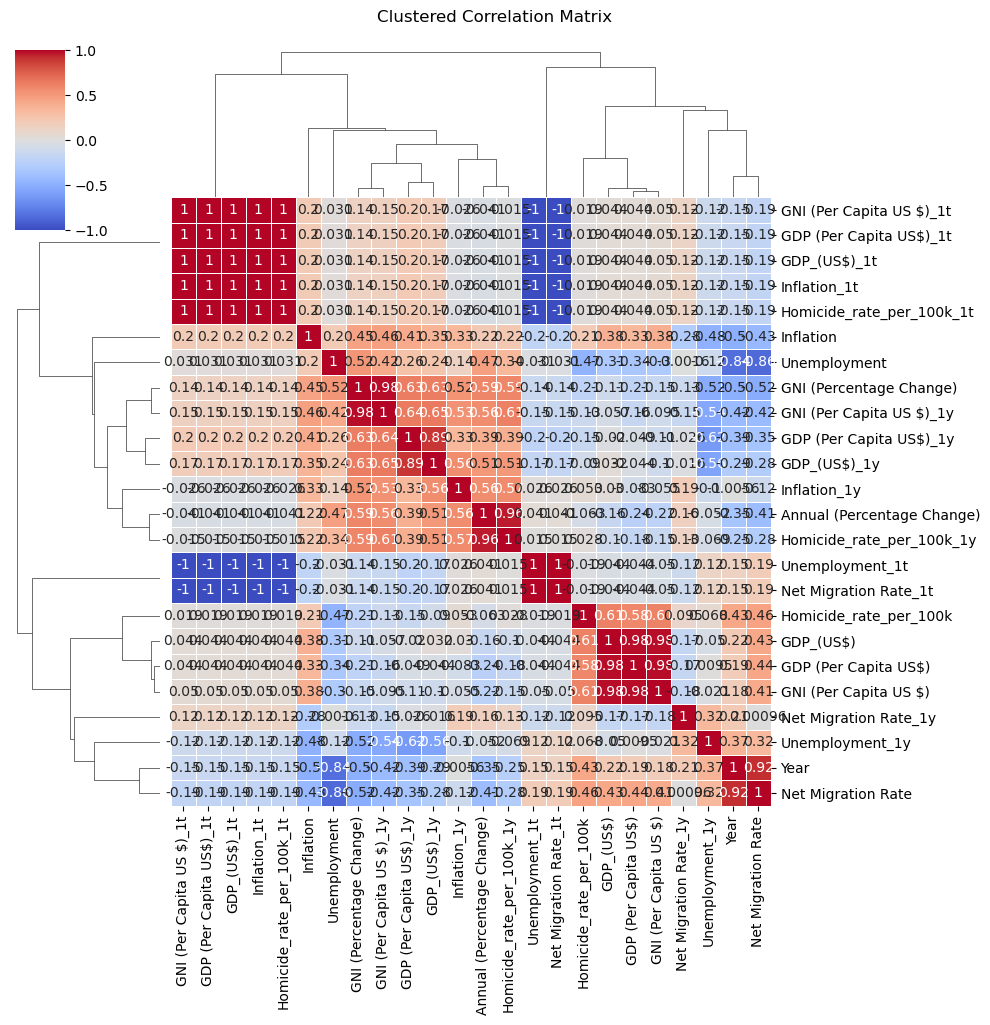

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

soc_info_07.fillna(0, inplace=True)
# Select only numeric features
numeric_df = soc_info_07.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', figsize=(10, 10), linewidths=0.5)
plt.suptitle("Clustered Correlation Matrix", y=1.02)
plt.show()

## Model Training
SVM

In [107]:
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


df = master_df.copy()

features = ['Year','GDP_(US$)', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'Inflation_1t', 'Inflation_1y', 'Unemployment_1t', 'Unemployment_1y', 'Net Migration Rate_1t',
            'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y', 'Homicide_rate_per_100k_1t', 'Homicide_rate_per_100k_1y'
            ,'GDP_(US$)_1y', 'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES','ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST'] 
target = 'P.N.M._VOTES_%'  # P.N.M. vote share as the target

X = df[features]
y = df[target]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# initialize and train the Support Vector Regression model
svr = SVR(kernel='linear', C=1, epsilon=0.1)  # change kernel as needed
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

#mse for eval
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2}")

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head())


Mean Squared Error: 0.021789377007902178
R² score: 0.3890395458998508
       Actual  Predicted
137  0.743823   0.707590
30   0.687817   0.417331
119  0.537743   0.429509
29   0.305307   0.349938
142  0.550374   0.393760


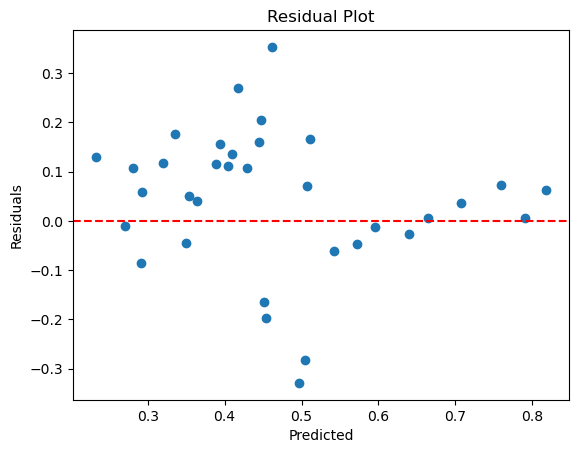

In [108]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

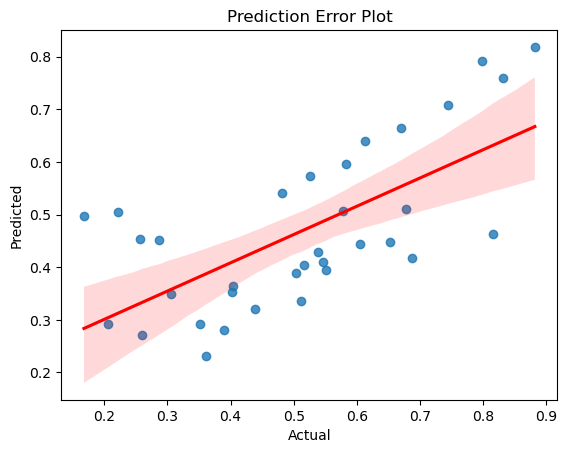

In [109]:
import seaborn as sns

sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction Error Plot")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Load and prepare your data
df = master_df.copy()
features = ['Year','GDP_(US$)', 'GNI (Per Capita US $)_1t', 'GNI (Per Capita US $)_1y', 'Inflation_1t', 'Inflation_1y', 'Unemployment_1t', 'Unemployment_1y', 'Net Migration Rate_1t',
            'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y', 'Homicide_rate_per_100k_1t', 'Homicide_rate_per_100k_1y'
            ,'GDP_(US$)_1y', 'VOTER_TURNOUT', 'REJECTED_BALLOTS', 'VALID_VOTES','ELECTORATE', 'TOTAL_NUMBER_OF_VOTES_CAST'] 
target = 'P.N.M._VOTES_%'

X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svr = SVR(kernel='linear')
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)


voting_regressor = VotingRegressor(estimators=[('svr', svr), ('rf', rf), ('gb', gb)])


param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.5], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVR(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters for SVR: {grid_search.best_params_}")


voting_regressor.fit(X_train, y_train)

y_pred = voting_regressor.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

cv_scores = cross_val_score(voting_regressor, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE: {-cv_scores.mean()}")

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head(10))


Best parameters for SVR: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
Mean Squared Error: 0.025548512131884932
R² score: 0.2836357566341272
Cross-validated MSE: 0.019901742005974464
       Actual  Predicted
137  0.743823   0.738861
30   0.687817   0.498533
119  0.537743   0.351308
29   0.305307   0.371114
142  0.550374   0.351408
161  0.515542   0.341707
164  0.669240   0.734307
51   0.351906   0.347471
105  0.511452   0.242828
60   0.797473   0.776018


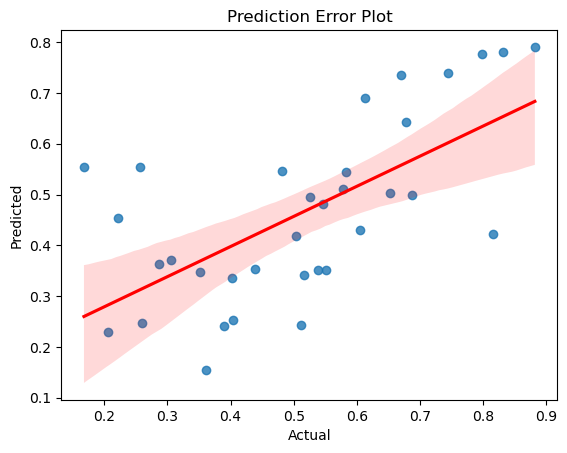

In [111]:
import seaborn as sns

sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction Error Plot")
plt.show()